# Credit Card Fraud Detection

In [1]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib


## Load datasets and view statistics

In [5]:
import os
import json
from zipfile import ZipFile
from PIL import Image


In [1]:
!pip install kaggle


In [6]:
kaggle_credentails = json.load(open("kaggle.json"))

In [7]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [8]:
!kaggle datasets download -d kartik2112/fraud-detection

Dataset URL: https://www.kaggle.com/datasets/kartik2112/fraud-detection
License(s): CC0-1.0




  0%|          | 0.00/202M [00:00<?, ?B/s]
  0%|          | 1.00M/202M [00:09<31:18, 112kB/s]
  1%|          | 2.00M/202M [00:18<30:40, 114kB/s]
  1%|▏         | 3.00M/202M [00:27<30:12, 115kB/s]
  2%|▏         | 4.00M/202M [00:35<28:45, 120kB/s]
  2%|▏         | 5.00M/202M [00:38<21:15, 162kB/s]
  3%|▎         | 6.00M/202M [00:40<16:07, 212kB/s]
  3%|▎         | 7.00M/202M [00:41<12:36, 270kB/s]
  4%|▍         | 8.00M/202M [00:43<10:08, 334kB/s]
  4%|▍         | 9.00M/202M [00:44<08:06, 416kB/s]
  5%|▍         | 10.0M/202M [00:45<06:34, 510kB/s]
  5%|▌         | 11.0M/202M [00:46<05:24, 617kB/s]
  6%|▌         | 12.0M/202M [00:47<04:31, 734kB/s]
  6%|▋         | 13.0M/202M [00:47<03:41, 896kB/s]
  7%|▋         | 14.0M/202M [00:48<03:03, 1.07MB/s]
  7%|▋         | 15.0M/202M [00:48<02:46, 1.17MB/s]
  8%|▊         | 16.0M/202M [00:49<02:27, 1.33MB/s]
  8%|▊         | 17.0M/202M [00:50<02:27, 1.32MB/s]
  9%|▉         | 18.0M/202M [00:51<02:36, 1.24MB/s]
  9%|▉         | 19.0M/202M [00:5

In [10]:
with ZipFile("fraud-detection.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [13]:

# Load datasets
train_data = pd.read_csv(r'fraudTrain.csv')
test_data = pd.read_csv(r'fraudTest.csv')

# Display dataset statistics
print("Train Dataset Overview:\n", train_data.describe())
print("Test Dataset Overview:\n", test_data.describe())


Train Dataset Overview:
          Unnamed: 0        cc_num           amt           zip           lat  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean   6.483370e+05  4.171920e+17  7.035104e+01  4.880067e+04  3.853762e+01   
std    3.743180e+05  1.308806e+18  1.603160e+02  2.689322e+04  5.075808e+00   
min    0.000000e+00  6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01   
25%    3.241685e+05  1.800429e+14  9.650000e+00  2.623700e+04  3.462050e+01   
50%    6.483370e+05  3.521417e+15  4.752000e+01  4.817400e+04  3.935430e+01   
75%    9.725055e+05  4.642255e+15  8.314000e+01  7.204200e+04  4.194040e+01   
max    1.296674e+06  4.992346e+18  2.894890e+04  9.978300e+04  6.669330e+01   

               long      city_pop     unix_time     merch_lat    merch_long  \
count  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06  1.296675e+06   
mean  -9.022634e+01  8.882444e+04  1.349244e+09  3.853734e+01 -9.022646e+01   
std    1.375908e+01  3.019

## Preprocess Data

In [14]:
# Preprocessing: Limit the number of categories for large categorical columns
def limit_categories(df, column, threshold=0.01):
    # Calculate the frequency of each category
    value_counts = df[column].value_counts(normalize=True)
    
    # Get the categories that appear above the threshold
    to_keep = value_counts[value_counts > threshold].index
    
    # Replace less frequent categories with "Other"
    df[column] = df[column].where(df[column].isin(to_keep), other='Other')

# Limit categories for 'merchant' and 'city'
limit_categories(train_data, 'merchant', threshold=0.01)
limit_categories(test_data, 'merchant', threshold=0.01)
limit_categories(train_data, 'city', threshold=0.01)
limit_categories(test_data, 'city', threshold=0.01)

# Feature selection (removing features not necessary for prediction)
X_train = train_data.drop(columns=['is_fraud', 'trans_num', 'cc_num', 'first', 'last', 'street', 'zip', 'dob', 'merchant', 'category', 'job', 'trans_date_trans_time'])
X_test = test_data.drop(columns=['is_fraud', 'trans_num', 'cc_num', 'first', 'last', 'street', 'zip', 'dob', 'merchant', 'category', 'job', 'trans_date_trans_time'])
y_train = train_data['is_fraud']
y_test = test_data['is_fraud']

# Convert categorical columns into dummy variables (one-hot encoding)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Ensure that both training and test sets have the same dummy variables
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Data scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Data Analysis

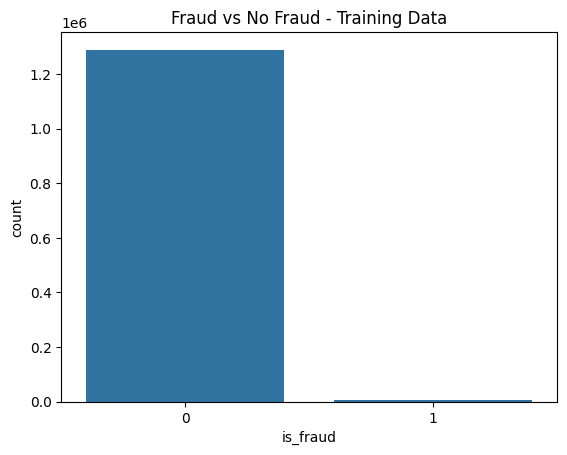

In [15]:

# Analyze the data (fraud vs no fraud counts)
sns.countplot(x='is_fraud', data=train_data)
plt.title('Fraud vs No Fraud - Training Data')
plt.show()


## Train Models

In [16]:

# Model building and training
algorithms = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

best_accuracy = 0
best_model = None
best_model_name = ""

for name, model in algorithms.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy * 100:.2f}%")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name


Logistic Regression Accuracy: 99.55%
Decision Tree Accuracy: 91.19%
Random Forest Accuracy: 99.61%


## Save the Best Model

In [17]:

# Save the best model
joblib.dump(best_model, 'credit_card_fraud_detection.pkl')
joblib.dump(scaler, 'scaler_fraud_detection.joblib')
joblib.dump(X_train.columns, 'X_train_columns.pkl')
print(f"Best Model: {best_model_name} with Accuracy: {best_accuracy * 100:.2f}%")



Best Model: Random Forest with Accuracy: 99.61%


## Confusion Matrix for Best Model

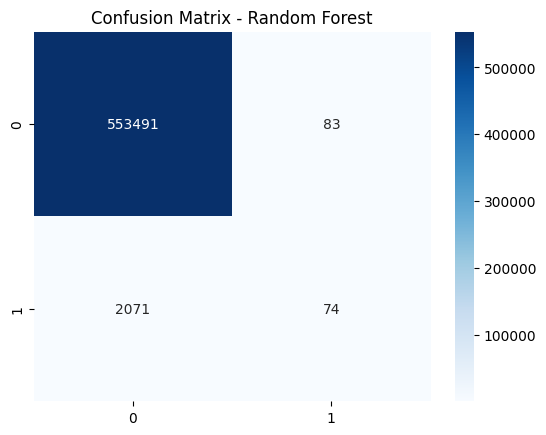

In [18]:

# Confusion matrix for the best model
y_pred_best = best_model.predict(X_test_scaled)
conf_matrix = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()


## Plot Histogram of Transaction Amounts

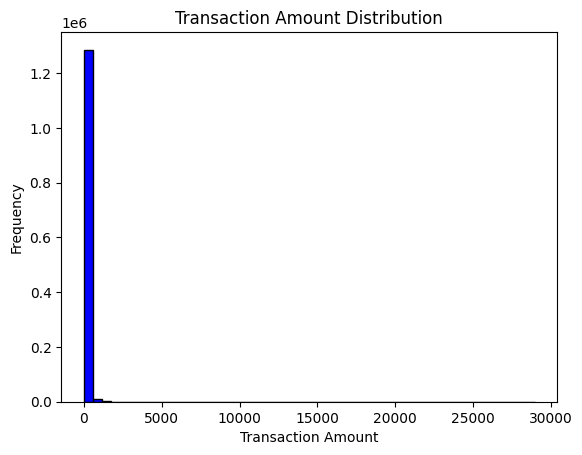

In [19]:

# Histogram of Amount (amt) feature
plt.hist(train_data['amt'], bins=50, color='blue', edgecolor='black')
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()


## Plot Fraud Count Graph

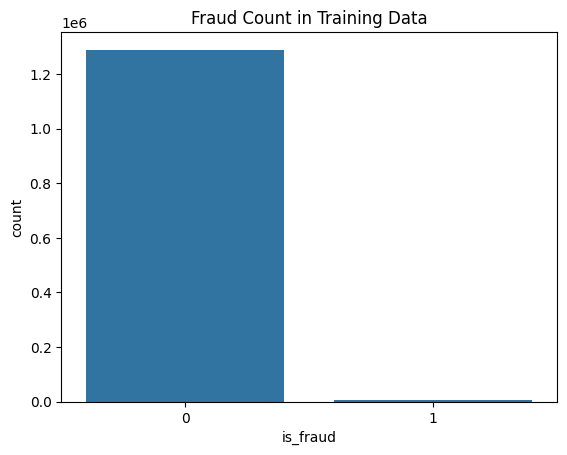

In [20]:

# Plot Fraud Count Graph
sns.countplot(x='is_fraud', data=train_data)
plt.title('Fraud Count in Training Data')
plt.show()


## Classification Report for Best Model

In [21]:

# Classification Report for the Best Model
print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best))


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.47      0.03      0.06      2145

    accuracy                           1.00    555719
   macro avg       0.73      0.52      0.53    555719
weighted avg       0.99      1.00      0.99    555719

